In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
import os
from langchain_core.messages import HumanMessage,AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START,END, StateGraph, MessagesState
from typing import Annotated, TypedDict, Literal
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain.tools.tavily_search import TavilySearchResults

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

In [4]:
search_tool = TavilySearchResults(tavily_api_key=tavily_key)

/var/folders/8g/sz3w79_54bgdwgjzjt0tn92h0000gn/T/ipykernel_12311/3021908779.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(tavily_api_key=tavily_key)


In [6]:
search_tool.invoke("What's going on between Trum and Musk ?")

[{'title': 'The Trump-Musk breakup appears to be complete | CNN Business',
  'url': 'https://www.cnn.com/2025/07/07/tech/elon-musk-donald-trump-breakup',
  'content': 'The brief détente between Elon Musk and President Donald Trump took its last breath over the weekend, as the billionaire and once top Republican donor announced he would form a new political party. [...] Musk over the past few days has not gone so far as to connect Trump personally to Epstein. But Musk made that allegation last month during his first public breakup with the president. Musk later deleted and expressed regret over those posts following phone conversations with Trump, Vice President JD Vance and White House chief of staff Susie Wiles. [...] In response to Musk’s threat to start a new political party, Trump threatened to investigate the billionaire’s government contracts and subsidies. Last week, Trump said DOGE may become a monster that may “go back and eat Elon.”\n\nMusk fires back\n---------------',
  'sc

In [7]:
repl = PythonREPL()

In [8]:
@tool
def repl_tool(code:Annotated[str,"The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try: 
        
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str


In [10]:
class Router(TypedDict):
    next: Literal['researcher','coder','FINISH']

In [11]:
class State(MessagesState):
    next: str

In [12]:
members = ['researcher','coder','FINISH']

In [13]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [14]:
llm = ChatOpenAI(model='gpt-4.1-2025-04-14')

In [16]:
def supervisor_agent(state:State)-> Command[Literal['researcher','coder','__end__']]:
    messages = [{'role':'system','content':system_prompt},] + state['messages']
    llm_with_structured_output = llm.with_structured_output(Router)

    response = llm_with_structured_output.invoke(messages)
    goto = response["next"]
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    if response == 'FINISH':
        goto = END
    return Command(update={"next": goto},goto=goto)
    

In [17]:
def research_agent(state:State) -> Command[Literal['supervisor']]:
    researcher_agent = create_react_agent(llm,tools=[search_tool],prompt="You are a researcher. DO NOT do any math.")
    result = researcher_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content,name='researcher')
            ]
        },
        goto="supervisor"
    )

In [18]:
def code_agent(state:State) -> Command[Literal['supervisor']]:
    coder_agent = create_react_agent(llm,tools=[repl_tool],prompt="You are a coder. DO NOT do any math.")
    result = coder_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content,name='coder')
            ]
        },
        goto="supervisor"
    )

In [19]:
graph = StateGraph(State)

In [20]:
graph.add_node("supervisor",supervisor_agent)
graph.add_node("researcher",research_agent)
graph.add_node("coder",code_agent)

graph.add_edge(START,"supervisor")

In [21]:
app = graph.compile()

In [22]:
from IPython.display import display,Image

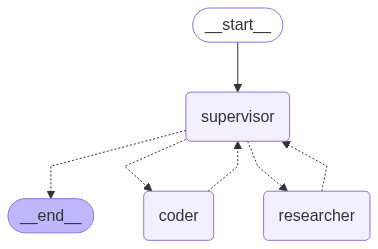

In [23]:
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


Python REPL can execute arbitrary code. Use with caution.


(('coder:5a4f11b4-b910-ec29-21a9-1e5a1985987a',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yruIWl1RUnKoVEShdkoiD3He', 'function': {'arguments': '{"code":"import math\\nprint(math.sqrt(42))"}', 'name': 'repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 105, 'total_tokens': 128, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b3f1157249', 'id': 'chatcmpl-BrBO6Mngv5wWyqEIQ8xn4704FnNKS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--86feae59-71d8-416e-9cfb-63f61a2b1ff1-0', tool_calls=[{'name': 'repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'call_yruIWl1RUnKoVEShdkoiD3He', 'type'

In [25]:
result=app.invoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)

**********BELOW IS MY GOTO***************
researcher
**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
FINISH


In [26]:
result

((),
 {'messages': [HumanMessage(content='what is an efficent python code to get prime number?', additional_kwargs={}, response_metadata={}, id='8baa885f-c376-4558-99cb-2bc00c118cf9'),
   HumanMessage(content='To efficiently find prime numbers in Python, one commonly used algorithm is the **Sieve of Eratosthenes** for generating all prime numbers up to a certain limit. For checking whether a single number is prime, you can use trial division up to the square root of the number.\n\nHere are two efficient code snippets:\n\n---\n\n### 1. **Sieve of Eratosthenes** (for all primes up to n)\n\n```python\ndef sieve_of_eratosthenes(limit):\n    is_prime = [True] * (limit + 1)\n    is_prime[0:2] = [False, False]\n    for number in range(2, int(limit ** 0.5) + 1):\n        if is_prime[number]:\n            for multiple in range(number*number, limit + 1, number):\n                is_prime[multiple] = False\n    primes = [i for i, prime in enumerate(is_prime) if prime]\n    return primes\n```\n\n-